In [1]:
"""
look at single gene classifiers within and across datasets
genes form Jessica

Shaina Lu
Zador & Gillis Labs
July 2020; Jan 2021
"""

'\nlook at single gene classifiers within and across datasets\ngenes form Jessica\n\nShaina Lu\nZador & Gillis Labs\nJuly 2020; Jan 2021\n'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #stratify train/test split
import random

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

# Read in files and pre-processing for cross dataset
copy from 09_crossdataset.ipynb

In [4]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"

In [7]:
#read in data
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()
STmeta, STspots, STpropont = read_STdata()

### pre-processing (as w/ model stuff)

In [6]:
#ABA
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology

In [8]:
def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    """helper function to get only leaf brain areas"""
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    print("number of leaf areas: %d" %len(leaves))
    return leaves

def findoverlapareas(STonto, propontvox, ontology):
    """find leaf brain areas overlapping between the two datasets"""
    leafST = getleaves(STonto, ontology)
    leafABA = getleaves(propontvox, ontology)

    leafboth = [] 
    for i in range(len(leafABA)):
        if leafABA[i] in leafST:
            leafboth.append(leafABA[i])
    
    STonto = STonto.loc[:,leafboth]
    propontvox = propontvox.loc[:,leafboth]
    
    return STonto, propontvox    

def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score on whole data set before splitting into test and train
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox

In [9]:
def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label (ctxnotctx)
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels)
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

__try skipping the box below for now and only filter for overlapping genes__

In [28]:
#filter brain areas for those that have at least x samples
STpropont = filterproponto(STpropont)
ABApropont = filterproponto(ABApropont)
#filter brain areas for overlapping leaf areas
STpropont, ABApropont = findoverlapareas(STpropont, ABApropont, ontology)

number of leaf areas: 461
number of leaf areas: 560


In [29]:
#keep only genes that are overlapping between the two datasets
STspots, ABAvox = getoverlapgenes(STspots, ABAvox)

number of overlapping genes: 14299


# 1. ALL BY ALL 4 GENE MODELS (below)

# Heatmap Plotting Functions

__upper triangular heat map__

In [35]:
def uppertriheatmap(allbyall):
    """get a first look at allbyall outfiles by visualizing as heat map"""
    plt.rcParams['figure.figsize'] = [10,10]
    sns.set()
    mask = np.zeros_like(allbyall)   #zero matrix of size allbyall
    mask[np.tril_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(allbyall, mask=mask, square=True, vmax=1, vmin=0)
        
    plt.show()

__cluster map code__

In [36]:
def clustermap(allbyall, ontology, filename):
    """create clustermap for given all by all"""
    #copy uppertriangular to lower triangular
    allbyall2 = allbyall
    allbyall2 = allbyall.fillna(0, inplace=False)
    temp = allbyall2.T
    allbyall2 = allbyall2.values  #convert to numpy
    temp = temp.values
    allbyall2[np.tril_indices_from(allbyall)] = temp[np.tril_indices_from(allbyall)]
    #are there any missing values in duplicated matrix?
    print("are there any missing values after copying over diagonal?")
    print(np.isnan(allbyall2).any())
    
    #color bar code to get rows indicated by region in cluster map
    #areas: CTX (incl hippo), CNU (striatum and pallidum),
    #IB (thalamus + hypothalamus), MB, HB, and CB (Cerebellum)
    #first get id's and allen color for these areas
    acros = ["CTX", "CNU", "IB", "MB", "HB", "CB", "root"]
    areaids = []
    allencolor = []
    for area in acros:
        areaids.append(ontology.loc[ontology.acronym == area, "id"].values[0])
        allencolor.append(ontology.loc[ontology.acronym == area, "allencolor"].values[0])
        
    #propogate brain areas up to sup structure for index
    supstrucs = []
    for area in list(allbyall):
        while int(area) not in areaids:
            area = int(ontology.loc[ontology.id==int(area),"parent"])
        supstrucs.append(int(area))
        
    #create color map for cluster map
    cbarmap = dict(zip(areaids,allencolor))
    row_colors = pd.Series(supstrucs).map(cbarmap)
    row_colors.name = " " #no name so it can be centered below
    row_colors.index = list(allbyall)

    #use a dataframeinstead for the colorbar 
    #to get wider colorbar by tricking multi-level labels
    row_colors_df = pd.DataFrame(row_colors)
    for i in range(10):
        if i == 5:
            row_colors_df["main brain areas"] = row_colors
            continue
        row_colors_df[" "*i] = row_colors
    
    #clustering using inverse of AUROC as distance
    #I think this is the correct one
    allbyall2_df = pd.DataFrame(allbyall2)
    allbyall2_df.set_index(pd.Index(list(allbyall)), inplace=True)
    allbyall2_df.index.name = "all brain areas"
    allbyall2_df.columns = list(allbyall)
    allbyall2_df.columns.name = "all brain areas"

    #use re-centered AUROC as similarity metric
    distm = np.abs(allbyall2_df - 0.5)        #center the aurocs at 0.5, get abs value
    np.fill_diagonal(distm.values, 0)         #force diagonal to be 0, required for linkage
    linkage = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(distm), method='average')

    #plot parameters
    plt.rcParams['figure.figsize'] = [10,10]
    sns.set(font_scale=1.25)

    g = clustmap = sns.clustermap(allbyall2_df, row_linkage=linkage, col_linkage=linkage,\
                                  square=True, xticklabels=False, yticklabels=False, vmax=1,\
                                  row_colors=row_colors_df, cbar_kws={'label': 'AUROC'})
    #legend hack
    legend_dict = dict(zip(acros, allencolor))
    for label in legend_dict.keys():
        g.ax_col_dendrogram.bar(0, 0, color=legend_dict[label],
                                label=label, linewidth=0)
        g.ax_col_dendrogram.legend(loc=[0,1], ncol=3, title="main brain areas")
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

__upper triangular histogram code__

In [37]:
def uppertrihist(allbyall, xaxislab, ylimflag, ylim1, ylim2, filename):
    """histogram of upper triangular of heatmaps"""
    allbyall = allbyall.values #convert to numpy
    histdata = allbyall[np.triu_indices_from(allbyall,k=1)]
    print("number of 0's in upper triangular: %d" %(len(np.where(histdata == 0)[0])))
    histdata = histdata[histdata != 0] #remove 0's
    
    #plot
    set_style()
    plt.hist(histdata, bins=100)
    plt.xlabel(xaxislab)
    plt.ylabel("counts")
    plt.axvline(x=np.mean(histdata), c="black", linestyle='--')
    plt.xlim([0,1.02])
    if ylimflag == 1:
        plt.ylim([ylim1,ylim2])
    
    if filename != 0:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    #mean AUROC for upper triangular
    print("mean AUROC for upper triangular: %f" %(np.mean(histdata)))

# Nr5a1

In [33]:
currgene = 'Nr5a1'

In [33]:
#initialize zeros dataframe to store entries
#allbyall_test = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ST = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ABA = pd.DataFrame(index=list(STpropont), columns=list(STpropont))

areas = list(STpropont)
#for each column, brain area
for i in range(STpropont.shape[1]):
#for i in range(5,6,1):
    print("col %d" %i)
    #for each row in each column
    for j in range(i+1,STpropont.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        #get binary label vectors
        yST = STpropont.loc[STpropont[area1]+STpropont[area2] != 0, area1]
        yABA = ABApropont.loc[ABApropont[area1]+ABApropont[area2] != 0, area1]
        #ylabels = pd.Series(np.random.permutation(ylabels1),index=ylabels1.index) #try permuting
        #subset train and test sets for only samples in the two areas
        XcurrST = STspots.loc[STpropont[area1]+STpropont[area2] != 0, currgene]
        XcurrABA = ABAvox.loc[ABApropont[area1]+ABApropont[area2] != 0, currgene]

        #z-score train and test folds
        zXST = sp.stats.zscore(XcurrST)
        zXABA = sp.stats.zscore(XcurrABA)

        #currauroc_train, currauroc_test, currauroc_cross = applyclassifer(zXtrain, zXtest, zXcross, ytrain, ytest, ycross)
        currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST), yST)
        currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA), yABA)
        
        allbyall_ST.iloc[i,j] = currauroc_ST
        allbyall_ABA.iloc[i,j] = currauroc_ABA

col 0


/home/slu/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


col 1
col 2
col 3
col 4
col 5
col 6
col 7
col 8
col 9
col 10
col 11
col 12
col 13
col 14
col 15
col 16
col 17
col 18
col 19
col 20
col 21
col 22
col 23
col 24
col 25
col 26
col 27
col 28
col 29
col 30
col 31
col 32
col 33
col 34
col 35
col 36
col 37
col 38
col 39
col 40
col 41
col 42
col 43
col 44
col 45
col 46
col 47
col 48
col 49
col 50
col 51
col 52
col 53
col 54
col 55
col 56
col 57
col 58
col 59
col 60
col 61
col 62
col 63
col 64
col 65
col 66
col 67
col 68
col 69
col 70
col 71
col 72
col 73
col 74
col 75
col 76
col 77
col 78
col 79
col 80
col 81
col 82
col 83
col 84
col 85
col 86
col 87
col 88
col 89
col 90
col 91
col 92
col 93
col 94
col 95
col 96
col 97
col 98
col 99
col 100
col 101
col 102
col 103
col 104
col 105
col 106
col 107
col 108
col 109
col 110
col 111
col 112
col 113
col 114
col 115
col 116
col 117
col 118
col 119
col 120
col 121
col 122
col 123
col 124
col 125
col 126
col 127
col 128
col 129
col 130
col 131
col 132
col 133
col 134
col 135
col 136
col 137
col 138
col 

In [34]:
allbyall_ST.head()

577       657      1114       606        472       632      1072  \
577   NaN  0.137267  0.966403  0.928854  0.0833333  0.761877  0.987923   
657   NaN       NaN  0.850649  0.751299   0.349405  0.711542  0.953968   
1114  NaN       NaN       NaN   0.47314   0.107955  0.311559  0.535354   
606   NaN       NaN       NaN       NaN   0.190341   0.39991  0.592172   
472   NaN       NaN       NaN       NaN        NaN  0.606236  0.837963   

           893        543      1088  ...       785        241       1104  \
577   0.783724   0.313665  0.975155  ...  0.386364  0.0791527   0.869565   
657   0.847985  0.0788265  0.872109  ...  0.386364   0.267216   0.930952   
1114  0.234266   0.417208       0.5  ...  0.386364   0.283217   0.227273   
606   0.261072   0.418831  0.557359  ...  0.386364   0.287296  0.0909091   
472    0.80235   0.715774  0.910714  ...  0.386364   0.626603   0.638889   

           702       954       325         87        82       684       234  
577   0.355556  0.328595  0.923913   0.852174  0.182065  0.518395  0.482143  
657   0.711111  0.546154  0.941071   0.945714  0.250446   0.49011  0.482143  
1114  0.164646  0.354021  0.693182   0.227273  0.278409  0.244755  0.482143  
606   0.239899  0.462413    0.6875  0.0977273  0.286932  0.555944  0.482143  
472   0.789815  0.831731   0.71875        0.8  0.838542   0.36859  0.482143  

[5 rows x 445 columns]

In [50]:
allbyall_ST = allbyall_ST.astype(np.float64)
allbyall_ABA = allbyall_ABA.astype(np.float64)

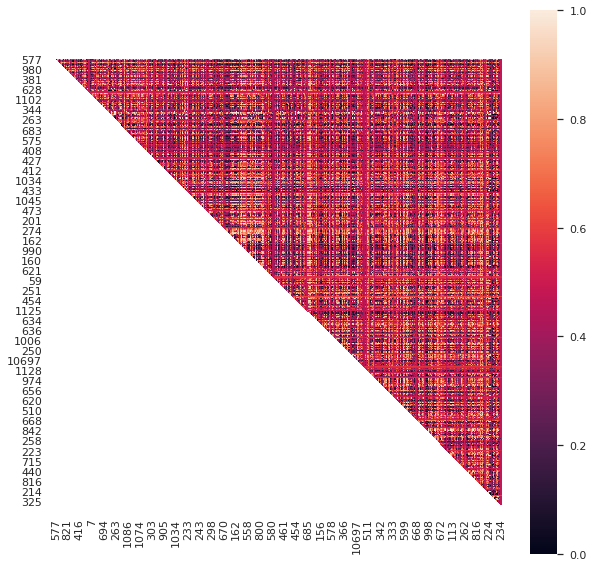

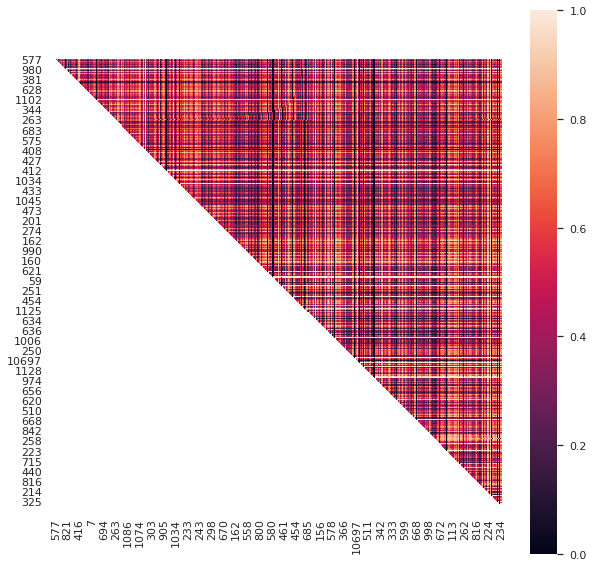

In [51]:
uppertriheatmap(allbyall_ST)
uppertriheatmap(allbyall_ABA)

are there any missing values after copying over diagonal?
False


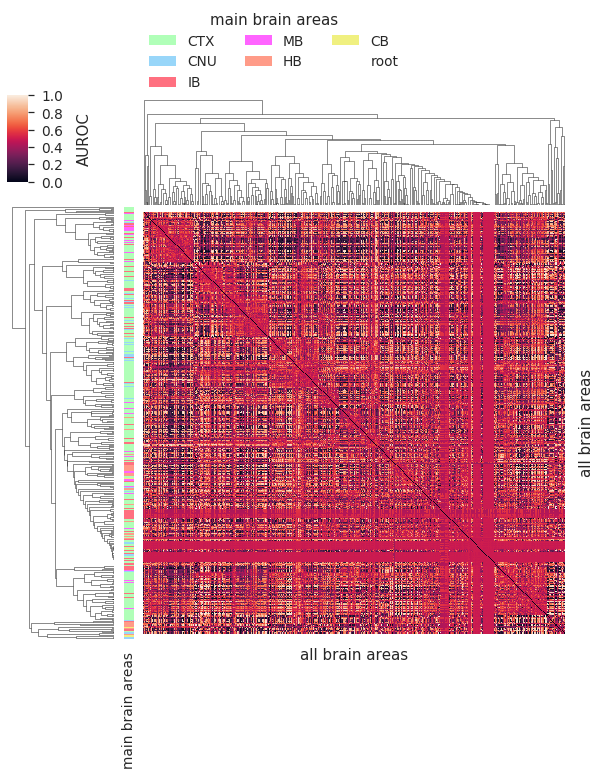

are there any missing values after copying over diagonal?
False


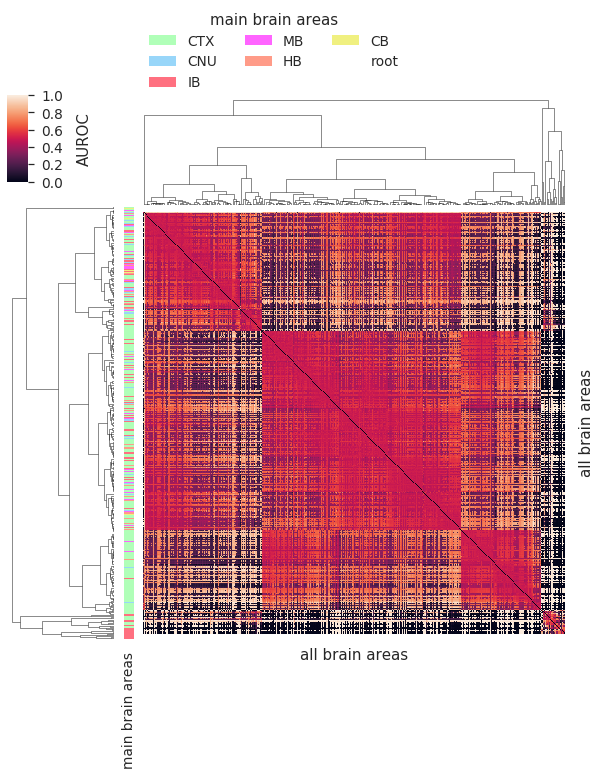

In [53]:
#clustermaps
clustermap(allbyall_ST, ontology, False)
clustermap(allbyall_ABA, ontology, False)

number of 0's in upper triangular: 173


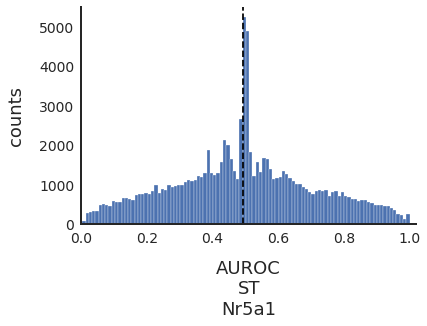

mean AUROC for upper triangular: 0.491662
number of 0's in upper triangular: 1815


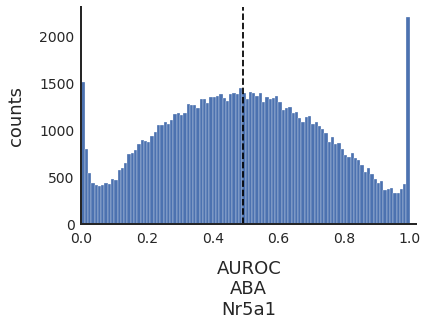

mean AUROC for upper triangular: 0.492573


In [55]:
uppertrihist(allbyall_ST, "AUROC\nST\n%s"%currgene, 0, 0, 0, False)
uppertrihist(allbyall_ABA, "AUROC\nABA\n%s"%currgene, 0, 0, 0, False)

# Pomc

In [56]:
currgene = 'Pomc'

In [ ]:
#initialize zeros dataframe to store entries
#allbyall_test = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ST = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ABA = pd.DataFrame(index=list(STpropont), columns=list(STpropont))

areas = list(STpropont)
#for each column, brain area
for i in range(STpropont.shape[1]):
#for i in range(5,6,1):
    print("col %d" %i)
    #for each row in each column
    for j in range(i+1,STpropont.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        #get binary label vectors
        yST = STpropont.loc[STpropont[area1]+STpropont[area2] != 0, area1]
        yABA = ABApropont.loc[ABApropont[area1]+ABApropont[area2] != 0, area1]
        #ylabels = pd.Series(np.random.permutation(ylabels1),index=ylabels1.index) #try permuting
        #subset train and test sets for only samples in the two areas
        XcurrST = STspots.loc[STpropont[area1]+STpropont[area2] != 0, currgene]
        XcurrABA = ABAvox.loc[ABApropont[area1]+ABApropont[area2] != 0, currgene]

        #z-score train and test folds
        zXST = sp.stats.zscore(XcurrST)
        zXABA = sp.stats.zscore(XcurrABA)

        #currauroc_train, currauroc_test, currauroc_cross = applyclassifer(zXtrain, zXtest, zXcross, ytrain, ytest, ycross)
        currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST), yST)
        currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA), yABA)
        
        allbyall_ST.iloc[i,j] = currauroc_ST
        allbyall_ABA.iloc[i,j] = currauroc_ABA

col 0
col 1
col 2
col 3
col 4
col 5
col 6
col 7
col 8
col 9
col 10
col 11
col 12
col 13
col 14
col 15
col 16
col 17
col 18
col 19
col 20
col 21
col 22
col 23
col 24
col 25


/home/slu/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


col 26
col 27
col 28
col 29
col 30
col 31
col 32
col 33
col 34
col 35
col 36
col 37
col 38
col 39
col 40
col 41
col 42
col 43
col 44
col 45
col 46
col 47
col 48
col 49
col 50
col 51
col 52
col 53
col 54
col 55
col 56
col 57
col 58
col 59
col 60
col 61
col 62
col 63
col 64
col 65
col 66
col 67
col 68
col 69
col 70
col 71
col 72
col 73
col 74
col 75
col 76
col 77
col 78
col 79
col 80
col 81
col 82
col 83
col 84
col 85
col 86
col 87
col 88
col 89
col 90
col 91
col 92
col 93
col 94
col 95
col 96
col 97
col 98
col 99
col 100
col 101
col 102
col 103
col 104
col 105
col 106
col 107
col 108
col 109
col 110
col 111
col 112
col 113
col 114
col 115
col 116
col 117
col 118
col 119
col 120
col 121
col 122
col 123
col 124
col 125
col 126
col 127
col 128
col 129
col 130
col 131
col 132
col 133
col 134
col 135
col 136
col 137
col 138
col 139
col 140
col 141
col 142
col 143
col 144
col 145
col 146
col 147
col 148
col 149
col 150
col 151
col 152
col 153
col 154
col 155
col 156
col 157
col 158
col 159
co

In [58]:
allbyall_ST.head()

577       657      1114       606       472       632      1072  \
577   NaN  0.514596  0.476285    0.4417  0.459239  0.478549  0.464976   
657   NaN       NaN  0.461688  0.427435  0.444643  0.464049   0.45119   
1114  NaN       NaN       NaN  0.464876  0.482955  0.502107  0.487374   
606   NaN       NaN       NaN       NaN  0.518466  0.536951  0.520833   
472   NaN       NaN       NaN       NaN       NaN   0.51904  0.503472   

           893       543      1088  ...       785       241      1104  \
577   0.406355  0.512811   0.49793  ...   0.43083  0.476589  0.521739   
657   0.391758  0.498214  0.483333  ...  0.416234  0.462179  0.507143   
1114   0.43007  0.536526  0.521645  ...  0.454545       0.5  0.545455   
606   0.466783   0.57082  0.556277  ...  0.490702  0.534674  0.579545   
472   0.447115  0.553571   0.53869  ...  0.471591  0.516827    0.5625   

           702       954       325        87        82       684       234  
577   0.488406  0.454431  0.521739  0.421739  0.506114  0.483278  0.468168  
657    0.47381  0.439835  0.507143  0.407143  0.491518  0.468681  0.453571  
1114  0.512121  0.478147  0.545455  0.445455   0.52983  0.506993  0.491883  
606    0.54697  0.513767  0.579545  0.481818  0.564276  0.541958  0.527192  
472   0.529167  0.495192    0.5625    0.4625  0.546875  0.524038  0.508929  

[5 rows x 445 columns]

In [59]:
allbyall_ST = allbyall_ST.astype(np.float64)
allbyall_ABA = allbyall_ABA.astype(np.float64)

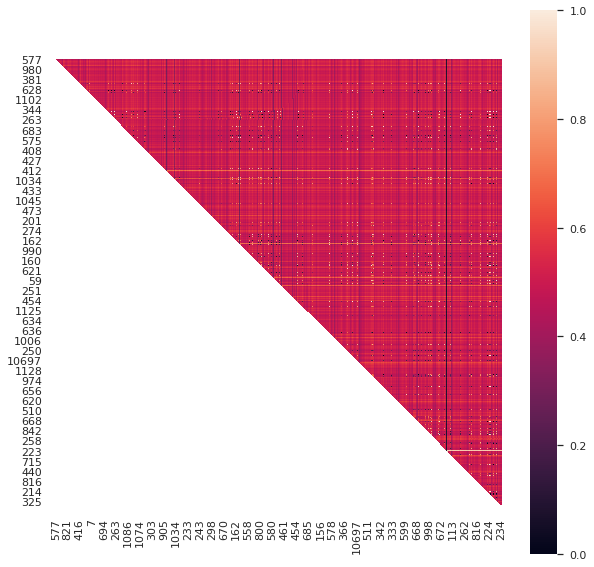

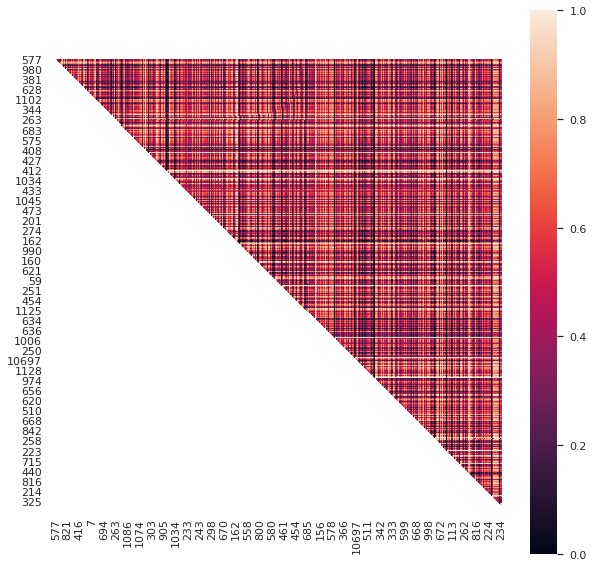

In [60]:
uppertriheatmap(allbyall_ST)
uppertriheatmap(allbyall_ABA)

are there any missing values after copying over diagonal?
False


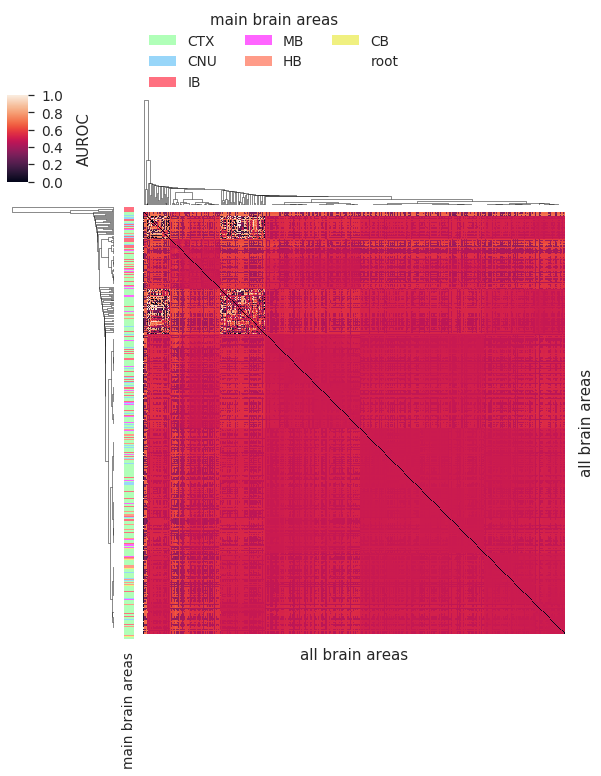

are there any missing values after copying over diagonal?
False


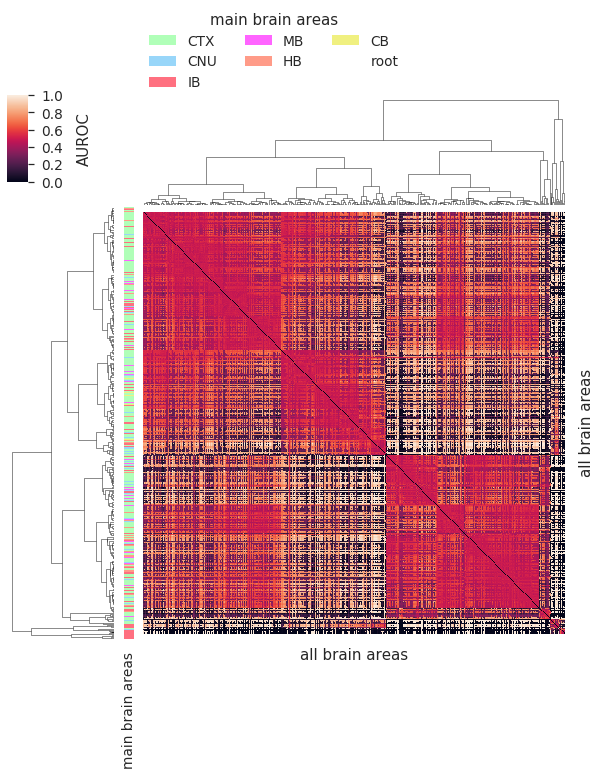

In [61]:
#clustermaps
clustermap(allbyall_ST, ontology, False)
clustermap(allbyall_ABA, ontology, False)

number of 0's in upper triangular: 44


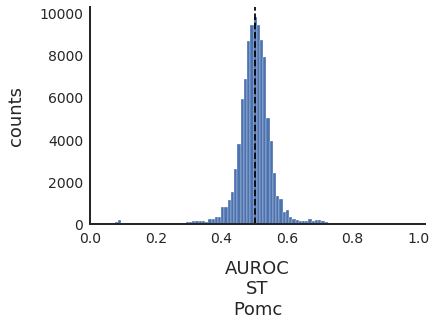

mean AUROC for upper triangular: 0.502122
number of 0's in upper triangular: 1172


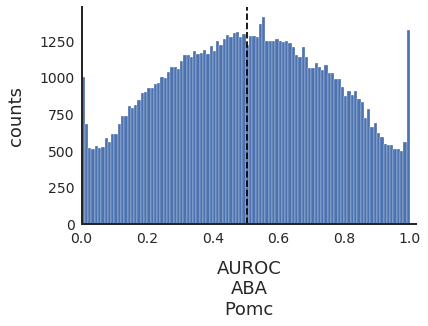

mean AUROC for upper triangular: 0.503516


In [62]:
uppertrihist(allbyall_ST, "AUROC\nST\n%s"%currgene, 0, 0, 0, "060320_1.pdf")
uppertrihist(allbyall_ABA, "AUROC\nABA\n%s"%currgene, 0, 0, 0, "060320_2.pdf")

# Esr2

In [95]:
currgene = 'Esr2'

In [96]:
#initialize zeros dataframe to store entries
#allbyall_test = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ST_Esr2 = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ABA_Esr2 = pd.DataFrame(index=list(STpropont), columns=list(STpropont))

areas = list(STpropont)
#for each column, brain area
for i in range(STpropont.shape[1]):
#for i in range(5,6,1):
    if (i%10) == 0:
        print("col %d" %i)
    #for each row in each column
    for j in range(i+1,STpropont.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        #get binary label vectors
        yST = STpropont.loc[STpropont[area1]+STpropont[area2] != 0, area1]
        yABA = ABApropont.loc[ABApropont[area1]+ABApropont[area2] != 0, area1]
        #ylabels = pd.Series(np.random.permutation(ylabels1),index=ylabels1.index) #try permuting
        #subset train and test sets for only samples in the two areas
        XcurrST = STspots.loc[STpropont[area1]+STpropont[area2] != 0, currgene]
        XcurrABA = ABAvox.loc[ABApropont[area1]+ABApropont[area2] != 0, currgene]

        #z-score train and test folds
        zXST = sp.stats.zscore(XcurrST)
        zXABA = sp.stats.zscore(XcurrABA)

        #currauroc_train, currauroc_test, currauroc_cross = applyclassifer(zXtrain, zXtest, zXcross, ytrain, ytest, ycross)
        currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST), yST)
        currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA), yABA)
        
        allbyall_ST_Esr2.iloc[i,j] = currauroc_ST
        allbyall_ABA_Esr2.iloc[i,j] = currauroc_ABA

col 0


/home/slu/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


col 10
col 20
col 30
col 40
col 50
col 60
col 70
col 80
col 90
col 100
col 110
col 120
col 130
col 140
col 150
col 160
col 170
col 180
col 190
col 200
col 210
col 220
col 230
col 240
col 250
col 260
col 270
col 280
col 290
col 300
col 310
col 320
col 330
col 340
col 350
col 360
col 370
col 380
col 390
col 400
col 410
col 420
col 430
col 440


In [97]:
allbyall_ST_Esr2.head()

577       657      1114       606       472       632      1072  \
577   NaN  0.137267  0.966403  0.928854  0.479167  0.761877  0.987923   
657   NaN       NaN  0.850649  0.751299  0.479167  0.711542  0.953968   
1114  NaN       NaN       NaN   0.47314  0.479167  0.311559  0.535354   
606   NaN       NaN       NaN       NaN  0.479167   0.39991  0.592172   
472   NaN       NaN       NaN       NaN       NaN  0.520833  0.520833   

           893        543      1088  ...        785        241       1104  \
577   0.783724   0.313665  0.975155  ...   0.786561  0.0791527   0.869565   
657   0.847985  0.0788265  0.872109  ...   0.880519   0.267216   0.930952   
1114  0.234266   0.417208       0.5  ...  0.0268595   0.283217   0.227273   
606   0.261072   0.418831  0.557359  ...       0.25   0.287296  0.0909091   
472   0.520833   0.520833  0.520833  ...   0.520833   0.520833   0.520833   

           702       954       325         87        82       684       234  
577   0.355556  0.328595  0.923913   0.852174  0.484375  0.461538   0.43323  
657   0.711111  0.546154  0.941071   0.945714  0.484375  0.461538  0.533673  
1114  0.164646  0.354021  0.693182   0.227273  0.484375  0.461538   0.23539  
606   0.239899  0.462413    0.6875  0.0977273  0.484375  0.461538  0.396104  
472   0.520833  0.520833  0.520833   0.520833  0.505208  0.482372  0.520833  

[5 rows x 445 columns]

In [98]:
allbyall_ST_Esr2 = allbyall_ST_Esr2.astype(np.float64)
allbyall_ABA_Esr2 = allbyall_ABA_Esr2.astype(np.float64)

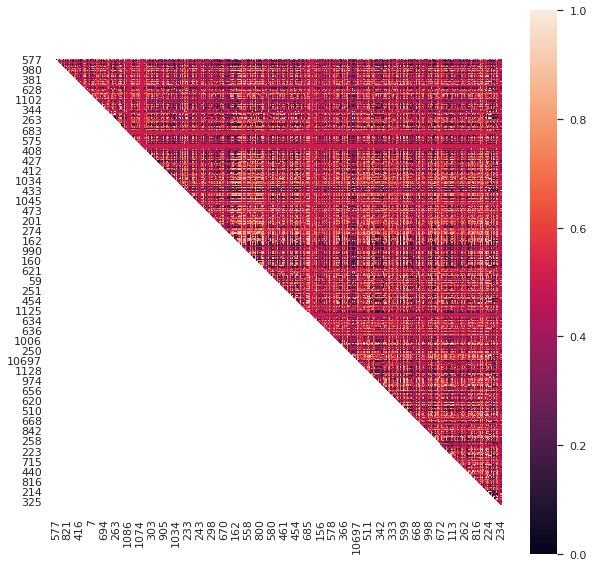

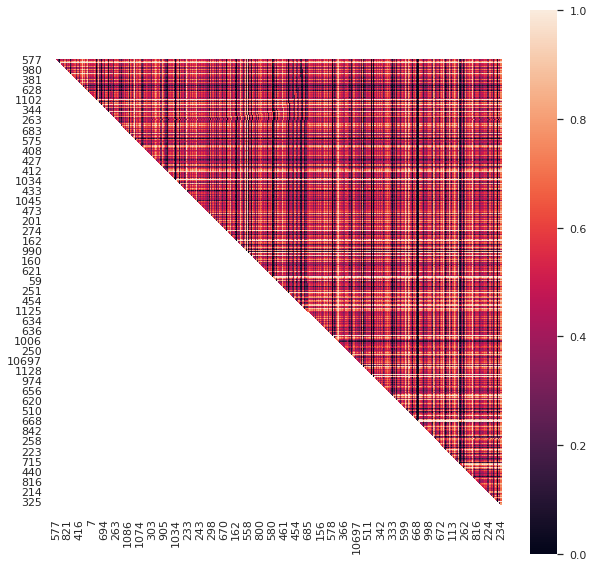

In [99]:
uppertriheatmap(allbyall_ST_Esr2)
uppertriheatmap(allbyall_ABA_Esr2)

are there any missing values after copying over diagonal?
False


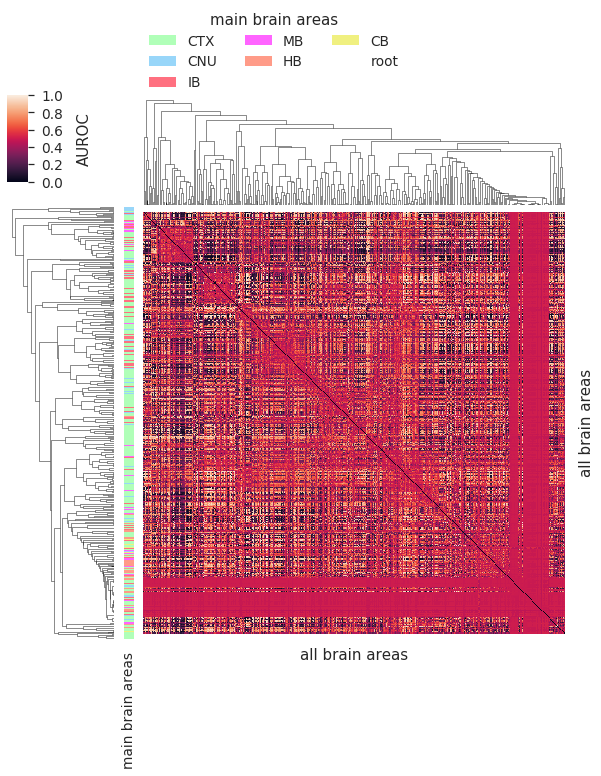

are there any missing values after copying over diagonal?
False


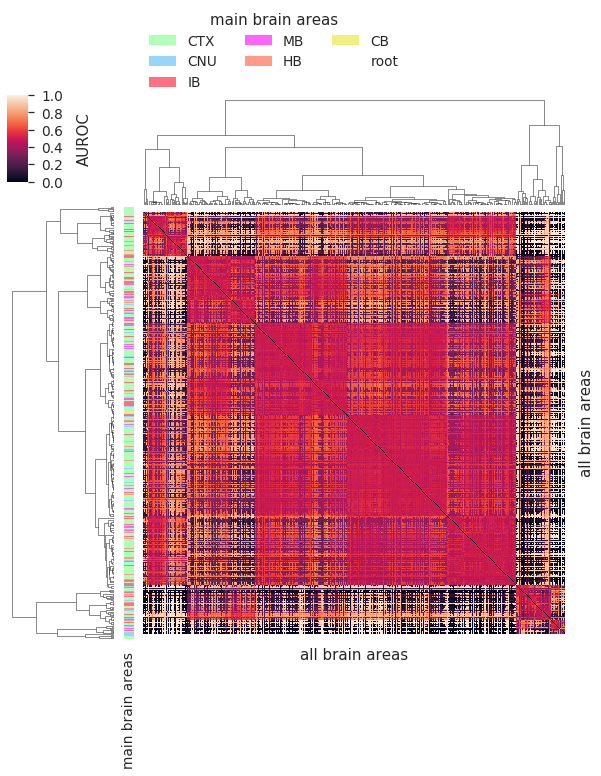

In [100]:
#clustermaps
clustermap(allbyall_ST_Esr2, ontology, False)
clustermap(allbyall_ABA_Esr2, ontology, False)

number of 0's in upper triangular: 180


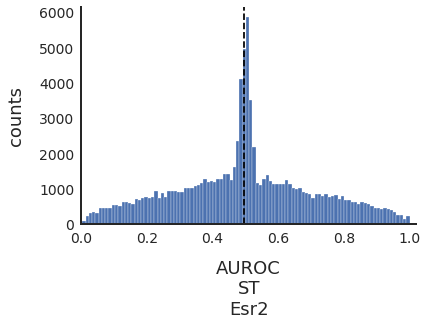

mean AUROC for upper triangular: 0.495852
number of 0's in upper triangular: 1000


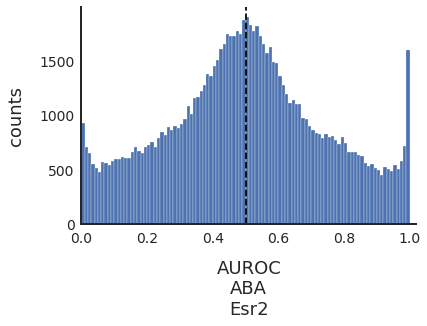

mean AUROC for upper triangular: 0.500198


In [101]:
uppertrihist(allbyall_ST_Esr2, "AUROC\nST\n%s"%currgene, 0, 0, 0, "070620_1.pdf")
uppertrihist(allbyall_ABA_Esr2, "AUROC\nABA\n%s"%currgene, 0, 0, 0, "070620_2.pdf")

# 4 Genes together
Just using all 4 genes together- mean of z-scored expression of all 4 genes, means re-ranked to get AUROC in each dataset

In [72]:
genes = ['Nr5a1', 'Pomc', 'Esr2', 'Amigo2']

In [ ]:
#initialize zeros dataframe to store entries
#allbyall_test = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ST_4genes = pd.DataFrame(index=list(STpropont), columns=list(STpropont))
allbyall_ABA_4genes = pd.DataFrame(index=list(STpropont), columns=list(STpropont))

areas = list(STpropont)
#for each column, brain area
for i in range(STpropont.shape[1]):
    if (i%10) == 0:
        print("col %d" %i)
    #for each row in each column
    for j in range(i+1,STpropont.shape[1]): #upper triangular!
        area1 = areas[i]
        area2 = areas[j]
        #get binary label vectors
        yST = STpropont.loc[STpropont[area1]+STpropont[area2] != 0, area1]
        yABA = ABApropont.loc[ABApropont[area1]+ABApropont[area2] != 0, area1]

        #subset train and test sets for only samples in the two areas
        XcurrST = STspots.loc[STpropont[area1]+STpropont[area2] != 0, genes]
        XcurrABA = ABAvox.loc[ABApropont[area1]+ABApropont[area2] != 0, genes]

        #z-score train and test folds
        zXST = zscore(XcurrST)
        zXABA = zscore(XcurrABA)
        
        #get AUROC of ranked mean
        currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.mean(axis=1)), yST)
        currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.mean(axis=1)), yABA)
        
        allbyall_ST_4genes.iloc[i,j] = currauroc_ST
        allbyall_ABA_4genes.iloc[i,j] = currauroc_ABA

col 0
col 10
col 20
col 30
col 40
col 50
col 60
col 70
col 80


In [87]:
allbyall_ST_4genes.head()

577       657      1114       606       472       632      1072  \
577   NaN  0.509627  0.513834  0.451581  0.268116  0.381227  0.384058   
657   NaN       NaN  0.504545  0.433766   0.25744  0.370293  0.375794   
1114  NaN       NaN       NaN  0.426136  0.266098  0.374925     0.375   
606   NaN       NaN       NaN       NaN  0.343277  0.443107  0.425505   
472   NaN       NaN       NaN       NaN       NaN  0.608582  0.603009   

           893       543      1088  ...       785       241      1104  \
577   0.418618  0.525233  0.431677  ...  0.244071  0.419175  0.586957   
657   0.411538  0.516199  0.421769  ...  0.234091  0.409707  0.578571   
1114  0.410256  0.509334  0.426407  ...  0.244835  0.409382  0.568182   
606   0.487179   0.58056   0.47619  ...  0.294938  0.483392  0.636364   
472   0.622863  0.756324  0.633929  ...  0.424242  0.653579    0.8125   

           702       954       325        87        82       684       234  
577   0.496135  0.462375  0.339674  0.426087  0.491168  0.292642  0.471273  
657   0.486508  0.454808  0.326786  0.415714   0.48192   0.27967   0.46352  
1114  0.482828  0.451049  0.326705  0.418182  0.477273  0.298951  0.457792  
606    0.54899  0.522509   0.40483  0.498864  0.536577  0.341783  0.530438  
472   0.724074  0.675881  0.585938  0.639583  0.717448  0.461538   0.68378  

[5 rows x 445 columns]

In [89]:
allbyall_ST_4genes = allbyall_ST_4genes.astype(np.float64)
allbyall_ABA_4genes = allbyall_ABA_4genes.astype(np.float64)

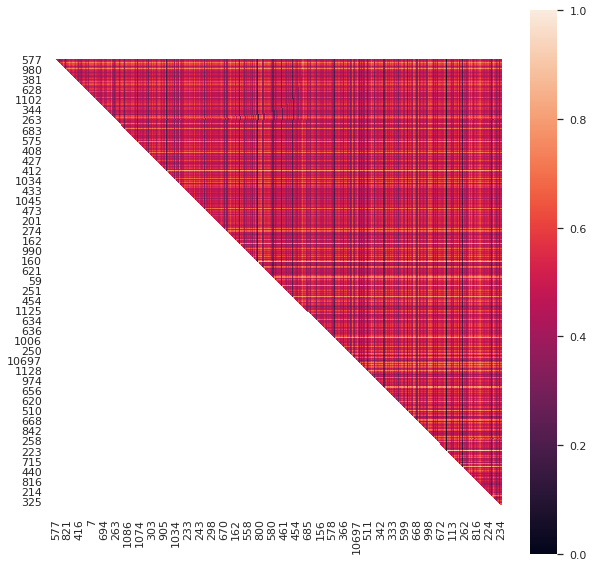

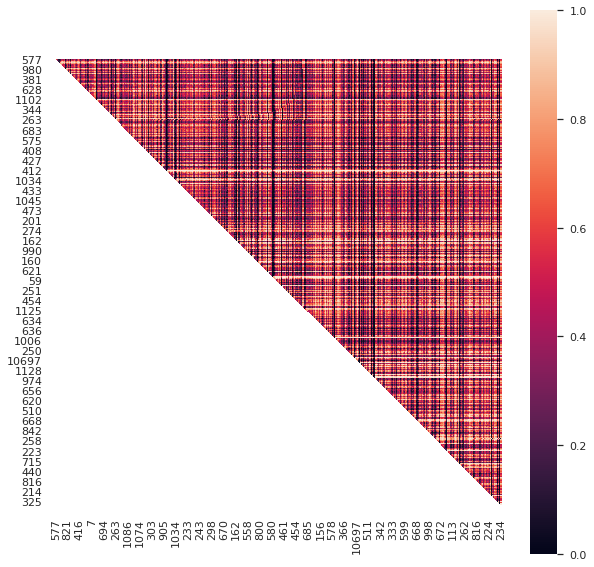

In [90]:
uppertriheatmap(allbyall_ST_4genes)
uppertriheatmap(allbyall_ABA_4genes)

are there any missing values after copying over diagonal?
False


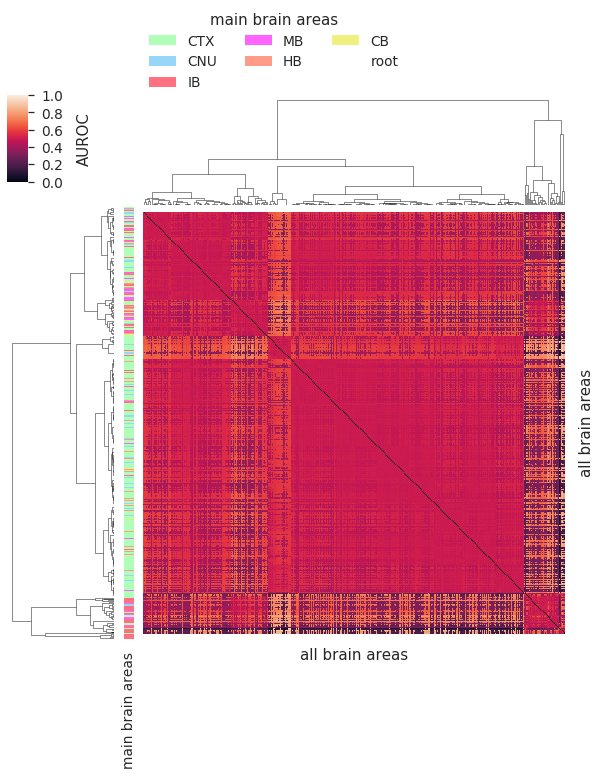

are there any missing values after copying over diagonal?
False


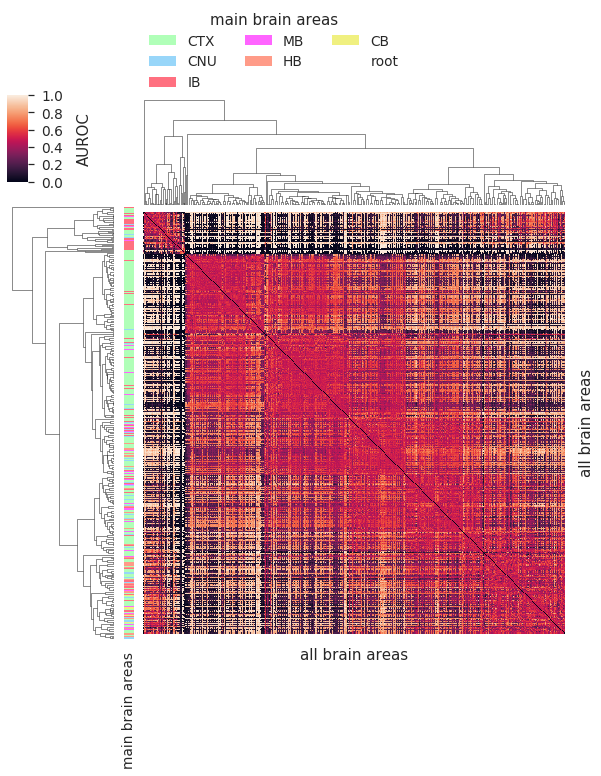

In [93]:
#clustermaps
clustermap(allbyall_ST_4genes, ontology, "070720_1.png")
clustermap(allbyall_ABA_4genes, ontology, "070720_2.png")

number of 0's in upper triangular: 44


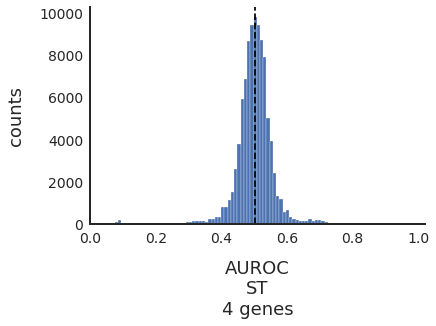

mean AUROC for upper triangular: 0.502122
number of 0's in upper triangular: 1172


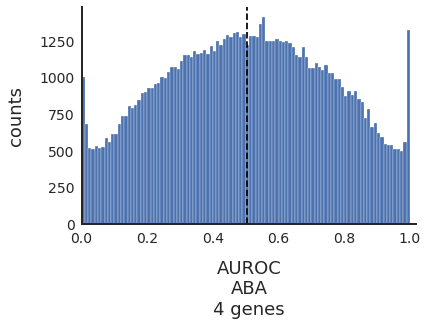

mean AUROC for upper triangular: 0.503516


In [94]:
uppertrihist(allbyall_ST, "AUROC\nST\n4 genes", 0, 0, 0, "070720_3.pdf")
uppertrihist(allbyall_ABA, "AUROC\nABA\n4 genes", 0, 0, 0, "070720_4.pdf")

# Single Gene, Single Area Classifiers
Look only at the brain areas where these genes are expressed

In [11]:
genes = ['Nr5a1', 'Pomc', 'Esr2', 'Amigo2']

## Amigo 2
Start w/ Amigo2 which has expression throughout the brain, but is a known marker of CA2; unfortunately CA2 does not appear to make it past initial filtering

Use datasets that are not filtered for brain areas and re-examine

In [12]:
ontology.loc[ontology.acronym == 'CA2']

id acronym       name  parent allencolor
51  423     CA2  Field CA2   375.0    #7ED04B

In [13]:
currarea = str(ontology.loc[ontology.acronym == 'CA2', 'id'].values[0])

In [14]:
print(ABApropont.loc[:,currarea].sum())
print(STpropont.loc[:,currarea].sum())

95.0
94.0


In [15]:
#get binary label vectors
yST = STpropont.loc[:, currarea]
yABA = ABApropont.loc[:, currarea]

#z-score whole dataset
zXST = zscore(STspots)
zXABA = zscore(ABAvox)

#get AUROC of ranked mean
currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.mean(axis=1)), yST)
currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.mean(axis=1)), yABA)

In [16]:
print(currauroc_ST)
print(currauroc_ABA)

0.37669475719054085
0.5269669400307534


In [17]:
#instead of using mean of all genes, just use Amigo2
currgene = 'Amigo2'
geneauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.loc[:,currgene]), yST)
geneauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.loc[:,currgene]), yABA)
print(geneauroc_ST)
print(geneauroc_ABA)

0.6117244886780443
0.9195847608513852


Using data that was not filtered for brain areas, we can classify CA2 very well using Amigo2 in ABA (auroc=0.920) realtive to using the mean of all genes (auroc = 0.527). Classifying CA2 in ST with only Amigo2 performs moderately well (auroc = 0.612) and with the mean of all genes auroc=0.377.

What if we now comapare to each of the genes as classifiers individually?

In [18]:
ST_allaurocs = zXST.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yST), axis=0)

In [19]:
ABA_allaurocs = zXABA.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yABA), axis=0)

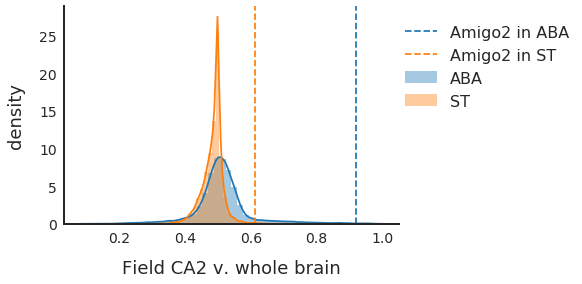

In [20]:
sns.distplot(ABA_allaurocs, label="ABA")
sns.distplot(ST_allaurocs, label="ST")
plt.axvline(geneauroc_ABA, color="C0", linestyle='--', label="%s in ABA"%currgene)
plt.axvline(geneauroc_ST, color="C1", linestyle='--', label="%s in ST"%currgene)
plt.xlabel("%s v. whole brain" %ontology.loc[ontology.id == int(currarea),'name'].iloc[0])
plt.ylabel("density")
plt.legend(loc=[1,0.5])
#plt.savefig("102220_2.pdf", bbox_inches='tight')
plt.show()

# Esr2
let's try a different gene perhaps also by visualizing where the expression is

In [50]:
currgene = "Esr2"

In [51]:
STareaexprs = pd.Series(index = list(STpropont))
for col in STpropont:
    STareaexprs[col] = (STpropont[col] * STspots[currgene]).sum()

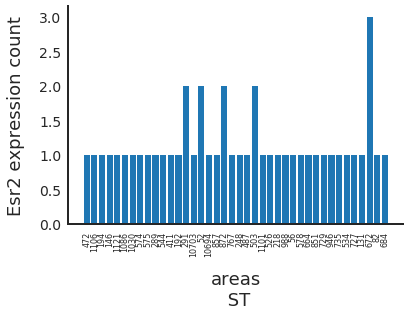

In [52]:
STareaexprs_nonzero = STareaexprs[STareaexprs>0]
plt.bar(STareaexprs_nonzero.index, STareaexprs_nonzero)
plt.xlabel("areas\n ST")
plt.ylabel("%s expression count" %currgene)
plt.xticks(rotation=90, fontsize=8)
#plt.savefig("071720_1.pdf", bbox_inches="tight")
plt.show()

In [53]:
#ABA
ABAareaexprs = pd.Series(index = list(ABApropont))
for col in ABApropont:
    ABAareaexprs[col] = (ABApropont[col] * ABAvox[currgene]).sum()

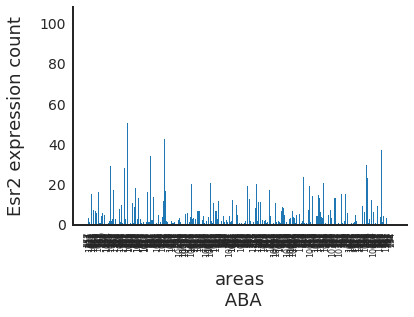

In [54]:
ABAareaexprs_nonzero = ABAareaexprs[ABAareaexprs>0]
plt.bar(ABAareaexprs_nonzero.index, ABAareaexprs_nonzero)
plt.xlabel("areas\n ABA")
plt.ylabel("%s expression count" %currgene)
plt.xticks(rotation=90, fontsize=8)
#plt.savefig("071720_2.pdf", bbox_inches="tight")
plt.show()

In [55]:
#currgene max express in each dataset
print(ABAareaexprs_nonzero.idxmax())
print(STareaexprs_nonzero.idxmax())

672
672


In [57]:
ontology.loc[ontology.id == 672,:]

id acronym          name  parent allencolor
1109  672      CP  Caudoputamen   485.0    #98D6F9

In [59]:
#33 areas overlaping with Pomc in both datasets
overlap = []
for i in range(len(STareaexprs_nonzero.index)):
    if STareaexprs_nonzero.index[i] in ABAareaexprs_nonzero.index:
        overlap.append(STareaexprs_nonzero.index[i])
        
print(len(overlap))

40


In [60]:
#index each dataset to have the same order
STareaexprs_nonzero = STareaexprs_nonzero[overlap]
ABAareaexprs_nonzero = ABAareaexprs_nonzero[overlap]

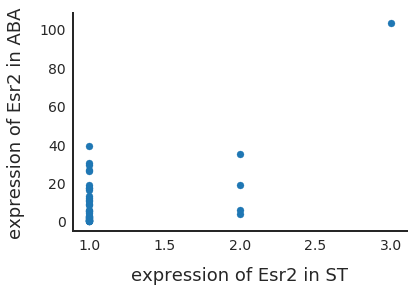

In [61]:
plt.scatter(STareaexprs_nonzero, ABAareaexprs_nonzero)
plt.xlabel("expression of %s in ST"%currgene)
plt.ylabel("expression of %s in ABA"%currgene)
plt.savefig("102120_4.pdf", bbox_inches='tight')

In [62]:
#max in both ST and ABA
print(STareaexprs_nonzero['672'])
print(ABAareaexprs_nonzero['672'])

3.0
103.02305961477126


In [63]:
currarea = '672'

In [64]:
#get binary label vectors
yST = STpropont.loc[:, currarea]
yABA = ABApropont.loc[:, currarea]

#z-score whole dataset
zXST = zscore(STspots)
zXABA = zscore(ABAvox)

#get AUROC of ranked mean
currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.mean(axis=1)), yST)
currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.mean(axis=1)), yABA)

In [65]:
print(currauroc_ST)
print(currauroc_ABA)

0.3958365688314271
0.38689037850111774


In [66]:
#instead of using mean of all genes, just use current gene
geneauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.loc[:,currgene]), yST)
geneauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.loc[:,currgene]), yABA)
print(geneauroc_ST)
print(geneauroc_ABA)

0.49987855373519474
0.44512717005622804


In [ ]:
#now look at each gene individually
ST_allaurocs = zXST.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yST), axis=0)
ABA_allaurocs = zXABA.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yABA), axis=0)

In [ ]:
sns.distplot(ABA_allaurocs, label="ABA")
sns.distplot(ST_allaurocs, label="ST")
plt.axvline(geneauroc_ABA, color="C0", linestyle='--', label="%s in ABA"%currgene)
plt.axvline(geneauroc_ST, color="C1", linestyle='--', label="%s in ST"%currgene)
plt.xlabel("%s v. whole brain" %ontology.loc[ontology.id == int(currarea),'name'].iloc[0])
plt.ylabel("density")
plt.legend(loc=[1,0.5])
plt.savefig("102120_5.pdf", bbox_inches='tight')
plt.show()

## Pomc
Tried this with the unfiltered areas as for Amigo2 (b/c CA2 gets filtered out), but that doesn't work here because you get grey as the highest expressed area.

In [30]:
currgene = "Pomc"

In [31]:
STareaexprs = pd.Series(index = list(STpropont))
for col in STpropont:
    STareaexprs[col] = (STpropont[col] * STspots[currgene]).sum()

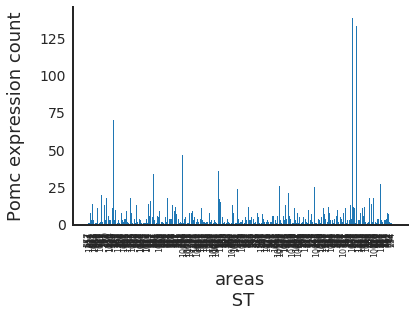

In [32]:
STareaexprs_nonzero = STareaexprs[STareaexprs>0]
plt.bar(STareaexprs_nonzero.index, STareaexprs_nonzero)
plt.xlabel("areas\n ST")
plt.ylabel("%s expression count" %currgene)
plt.xticks(rotation=90, fontsize=8)
#plt.savefig("071720_1.pdf", bbox_inches="tight")
plt.show()

In [33]:
#ABA
ABAareaexprs = pd.Series(index = list(ABApropont))
for col in ABApropont:
    ABAareaexprs[col] = (ABApropont[col] * ABAvox[currgene]).sum()

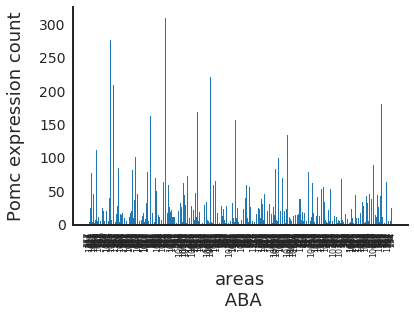

In [34]:
ABAareaexprs_nonzero = ABAareaexprs[ABAareaexprs>0]
plt.bar(ABAareaexprs_nonzero.index, ABAareaexprs_nonzero)
plt.xlabel("areas\n ABA")
plt.ylabel("%s expression count" %currgene)
plt.xticks(rotation=90, fontsize=8)
#plt.savefig("071720_2.pdf", bbox_inches="tight")
plt.show()

In [35]:
#Pomc max express in each dataset
print(ABAareaexprs_nonzero.idxmax())
print(STareaexprs_nonzero.idxmax())

962
672


In [36]:
ontology.loc[ontology.id == 223,:]

id acronym                          name  parent allencolor
1126  223     ARH  Arcuate hypothalamic nucleus   157.0    #FF5D50

In [37]:
#374 areas overlaping with Pomc in both datasets
overlap = []
for i in range(len(STareaexprs_nonzero.index)):
    if STareaexprs_nonzero.index[i] in ABAareaexprs_nonzero.index:
        overlap.append(STareaexprs_nonzero.index[i])
        
print(len(overlap))

374


In [38]:
#index each dataset to have the same order
STareaexprs_nonzero = STareaexprs_nonzero[overlap]
ABAareaexprs_nonzero = ABAareaexprs_nonzero[overlap]

Text(0, 0.5, 'expression of Pomc in ABA')

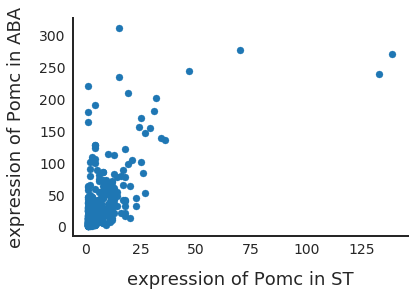

In [39]:
plt.scatter(STareaexprs_nonzero, ABAareaexprs_nonzero)
plt.xlabel("expression of %s in ST"%currgene)
plt.ylabel("expression of %s in ABA"%currgene)
#plt.savefig("102120_1.pdf", bbox_inches='tight')

In [40]:
#second largest in ST is ARH which is also high counts for ABA
STareaexprs_nonzero['223']
ABAareaexprs_nonzero['223']

238.53621318936348

In [41]:
currarea = '223'

In [42]:
#get binary label vectors
yST = STpropont.loc[:, currarea]
yABA = ABApropont.loc[:, currarea]

#z-score whole dataset
zXST = zscore(STspots)
zXABA = zscore(ABAvox)

#get AUROC of ranked mean
currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.mean(axis=1)), yST)
currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.mean(axis=1)), yABA)

In [43]:
print(currauroc_ST)
print(currauroc_ABA)

0.42474151309159414
0.6461445925925926


In [44]:
#instead of using mean of all genes, just use Pomc
geneauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.loc[:,currgene]), yST)
geneauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.loc[:,currgene]), yABA)
print(geneauroc_ST)
print(geneauroc_ABA)

0.9100954900172638
0.9929700740740741


In [45]:
#now look at each gene individually
ST_allaurocs = zXST.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yST), axis=0)
ABA_allaurocs = zXABA.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yABA), axis=0)

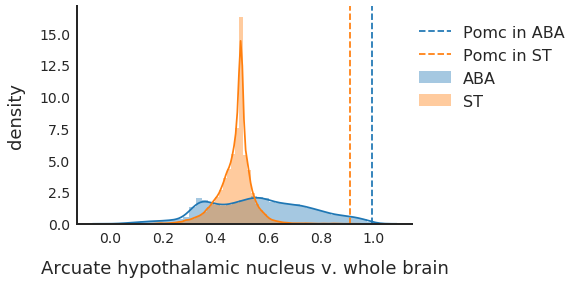

In [159]:
sns.distplot(ABA_allaurocs, label="ABA")
sns.distplot(ST_allaurocs, label="ST")
plt.axvline(geneauroc_ABA, color="C0", linestyle='--', label="%s in ABA"%currgene)
plt.axvline(geneauroc_ST, color="C1", linestyle='--', label="%s in ST"%currgene)
plt.xlabel("%s v. whole brain" %ontology.loc[ontology.id == int(currarea),'name'].iloc[0])
plt.ylabel("density")
plt.legend(loc=[1,0.5])
#plt.savefig("102220_1.pdf", bbox_inches='tight')
plt.show()

## Nr5a1

In [26]:
currgene = "Nr5a1"

In [28]:
STareaexprs = pd.Series(index = list(STpropont))
for col in STpropont:
    STareaexprs[col] = (STpropont[col] * STspots[currgene]).sum()

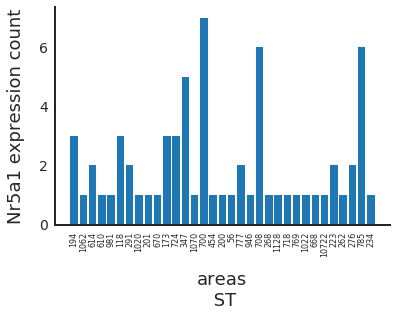

In [29]:
STareaexprs_nonzero = STareaexprs[STareaexprs>0]
plt.bar(STareaexprs_nonzero.index, STareaexprs_nonzero)
plt.xlabel("areas\n ST")
plt.ylabel("%s expression count" %currgene)
plt.xticks(rotation=90, fontsize=8)
#plt.savefig("071720_1.pdf", bbox_inches="tight")
plt.show()

In [30]:
#ABA
ABAareaexprs = pd.Series(index = list(ABApropont))
for col in ABApropont:
    ABAareaexprs[col] = (ABApropont[col] * ABAvox[currgene]).sum()

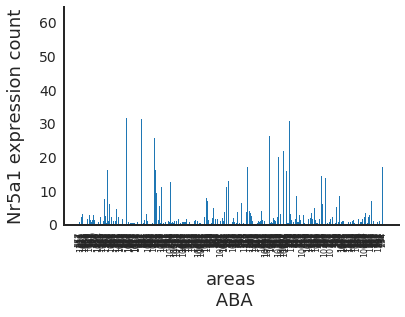

In [31]:
ABAareaexprs_nonzero = ABAareaexprs[ABAareaexprs>0]
plt.bar(ABAareaexprs_nonzero.index, ABAareaexprs_nonzero)
plt.xlabel("areas\n ABA")
plt.ylabel("%s expression count" %currgene)
plt.xticks(rotation=90, fontsize=8)
#plt.savefig("071720_2.pdf", bbox_inches="tight")
plt.show()

In [32]:
#Pomc max express in each dataset
print(ABAareaexprs_nonzero.idxmax())
print(STareaexprs_nonzero.idxmax())

194
700


In [43]:
ontology.loc[ontology.id == 708,:]

id acronym                                         name  parent  \
852  708    AHNc  Anterior hypothalamic nucleus, central part    88.0   

    allencolor  
852    #FF4C3E

In [35]:
#33 areas overlaping with Pomc in both datasets
overlap = []
for i in range(len(STareaexprs_nonzero.index)):
    if STareaexprs_nonzero.index[i] in ABAareaexprs_nonzero.index:
        overlap.append(STareaexprs_nonzero.index[i])
        
print(len(overlap))

33


In [36]:
#index each dataset to have the same order
STareaexprs_nonzero = STareaexprs_nonzero[overlap]
ABAareaexprs_nonzero = ABAareaexprs_nonzero[overlap]

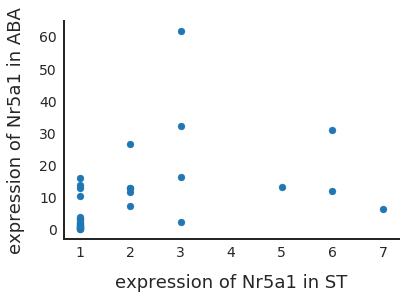

In [37]:
plt.scatter(STareaexprs_nonzero, ABAareaexprs_nonzero)
plt.xlabel("expression of %s in ST"%currgene)
plt.ylabel("expression of %s in ABA"%currgene)
plt.savefig("102120_2.pdf", bbox_inches='tight')

In [42]:
#second largest in ST is ARH which is also high counts for ABA
print(STareaexprs_nonzero['708'])
print(ABAareaexprs_nonzero['708'])

6.0
30.95023973658681


In [44]:
currarea = '708'

In [45]:
#get binary label vectors
yST = STpropont.loc[:, currarea]
yABA = ABApropont.loc[:, currarea]

#z-score whole dataset
zXST = zscore(STspots)
zXABA = zscore(ABAvox)

#get AUROC of ranked mean
currauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.mean(axis=1)), yST)
currauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.mean(axis=1)), yABA)

In [46]:
print(currauroc_ST)
print(currauroc_ABA)

0.48392904289797617
0.5045773848376574


In [47]:
#instead of using mean of all genes, just use current gene
geneauroc_ST = analytical_auroc(sp.stats.mstats.rankdata(zXST.loc[:,currgene]), yST)
geneauroc_ABA = analytical_auroc(sp.stats.mstats.rankdata(zXABA.loc[:,currgene]), yABA)
print(geneauroc_ST)
print(geneauroc_ABA)

0.5726115496611707
0.9541309994065584


In [ ]:
#now look at each gene individually
ST_allaurocs = zXST.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yST), axis=0)
ABA_allaurocs = zXABA.apply(lambda col: analytical_auroc(sp.stats.mstats.rankdata(col),yABA), axis=0)

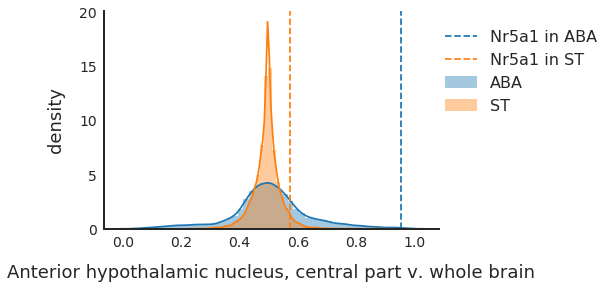

In [49]:
sns.distplot(ABA_allaurocs, label="ABA")
sns.distplot(ST_allaurocs, label="ST")
plt.axvline(geneauroc_ABA, color="C0", linestyle='--', label="%s in ABA"%currgene)
plt.axvline(geneauroc_ST, color="C1", linestyle='--', label="%s in ST"%currgene)
plt.xlabel("%s v. whole brain" %ontology.loc[ontology.id == int(currarea),'name'].iloc[0])
plt.ylabel("density")
plt.legend(loc=[1,0.5])
plt.savefig("102120_3.pdf", bbox_inches='tight')
plt.show()